Мирошниченко Максим Игоревич
гр. 21426


In [432]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn import preprocessing, decomposition, manifold, model_selection, pipeline, cluster, datasets, mixture, metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_curve, precision_score, roc_auc_score, f1_score

from sklearn.svm import LinearSVC, SVC

from IPython.display import Image
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline 

In [4]:
data_train = pd.read_csv("griby_train.txt")
data_test = pd.read_csv("griby_test.txt")

- - -
### 2. Разведочный анализ данных

In [5]:
data = pd.concat([data_test, data_train])

In [6]:
print(data.isnull().values.any())

False


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3051 entries, 0 to 2103
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     3051 non-null   object
 1   cap_shape                 3051 non-null   object
 2   cap_surface               3051 non-null   object
 3   cap_color                 3051 non-null   object
 4   bruises                   3051 non-null   object
 5   odor                      3051 non-null   object
 6   gill_attachment           3051 non-null   object
 7   gill_spacing              3051 non-null   object
 8   gill_size                 3051 non-null   object
 9   gill_color                3051 non-null   object
 10  stalk_shape               3051 non-null   object
 11  stalk_root                3051 non-null   object
 12  stalk_surface_above_ring  3051 non-null   object
 13  stalk_surface_below_ring  3051 non-null   object
 14  stalk_color_above_ring  

In [8]:
data

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,edible,convex,smooth,brown,no,none,attached,close,broad,orange,...,smooth,orange,orange,partial,orange,one,pendant,brown,clustered,leaves
1,poisonous,flat,fibrous,yellow,no,none,free,close,narrow,white,...,scaly,white,yellow,partial,white,one,evanescent,white,several,woods
2,edible,flat,scaly,brown,bruises,anise,free,close,broad,pink,...,scaly,white,white,partial,white,one,pendant,brown,solitary,grasses
3,edible,convex,scaly,gray,bruises,none,free,close,broad,white,...,smooth,white,pink,partial,white,one,pendant,black,several,woods
4,edible,bell,scaly,yellow,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,poisonous,convex,scaly,red,no,fishy,free,close,narrow,buff,...,smooth,white,white,partial,white,one,evanescent,white,several,leaves
2100,poisonous,flat,smooth,white,bruises,foul,free,close,broad,pink,...,smooth,white,white,partial,white,one,pendant,chocolate,scattered,grasses
2101,poisonous,convex,smooth,brown,no,fishy,free,close,narrow,buff,...,silky,pink,pink,partial,white,one,evanescent,white,several,leaves
2102,edible,convex,fibrous,white,no,none,free,crowded,broad,pink,...,smooth,white,white,partial,white,one,evanescent,brown,scattered,grasses


In [10]:
df_col = list(data.columns[1:])

In [24]:
def trim_axes(axes, N):
    axes = axes.flat
    for ax in axes[N:]:
        ax.remove()
    return axes[:N]

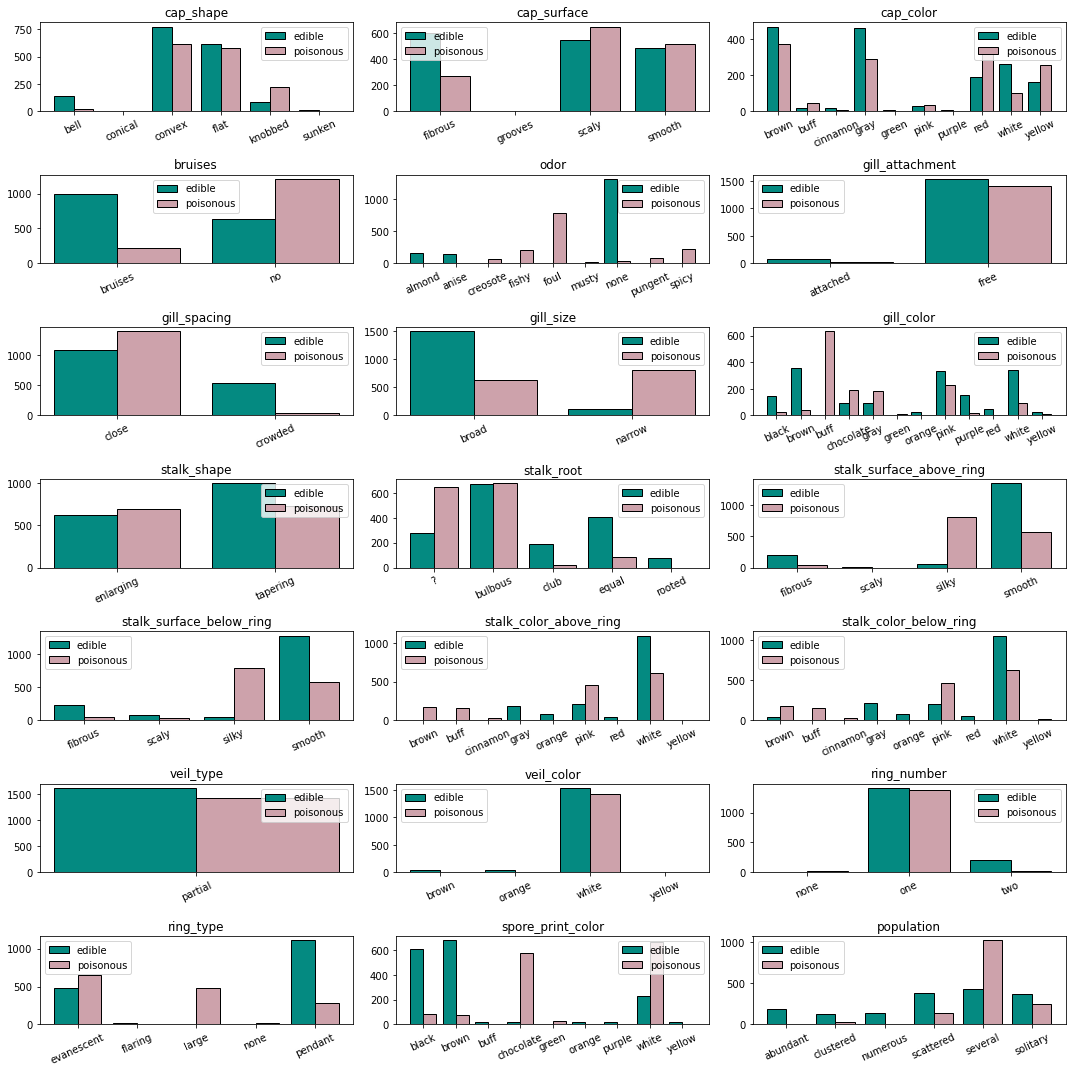

In [125]:
figure, axes = plt.subplots(nrows=7, ncols=3, figsize=(15,15))
axes = trim_axes(axes, len(df_col))
for i, ax in enumerate(axes.ravel()):
    trans_data = data[[df_col[i],'class']].groupby([df_col[i], 'class']).size().unstack()
    ind = np.arange(len(list(trans_data.index)))
    width = 0.4
    b1 = ax.bar(ind - width/2, list(trans_data.loc[:, 'edible'].fillna(0)), width, color='#048A81', edgecolor='black')
    b2 = ax.bar(ind + width/2, list(trans_data.loc[:, 'poisonous'].fillna(0)), width, color='#CDA2AB', edgecolor='black')
    ax.set_xticks(ind)
    ax.set_xticklabels(list(trans_data.index), rotation=25)
    ax.legend((b1[0], b2[0]), ('edible', 'poisonous'))
    ax.set_title(df_col[i])

figure.tight_layout()
plt.show()

In [398]:
data_train_X = pd.get_dummies(data_train)
data_hold_out_X = pd.get_dummies(data_test)

In [401]:
data_train_X, data_hold_out_X = data_train_X.align(data_hold_out_X, join='outer', axis=1, fill_value=0)

In [402]:
print(data_train_X.shape[1])
print(data_hold_out_X.shape[1])

119
119


C:\Anaconda\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


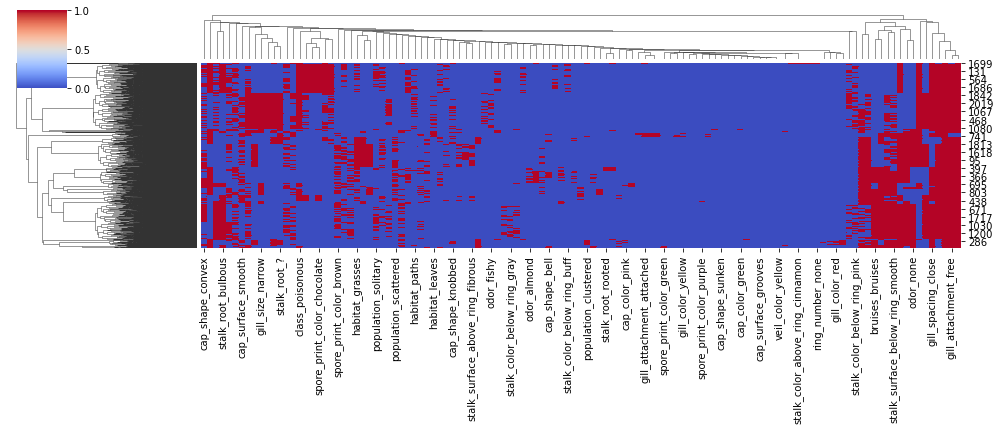

In [184]:
sns.clustermap(data_train_X, metric='euclidean',  cmap = "coolwarm", figsize = [14,6])

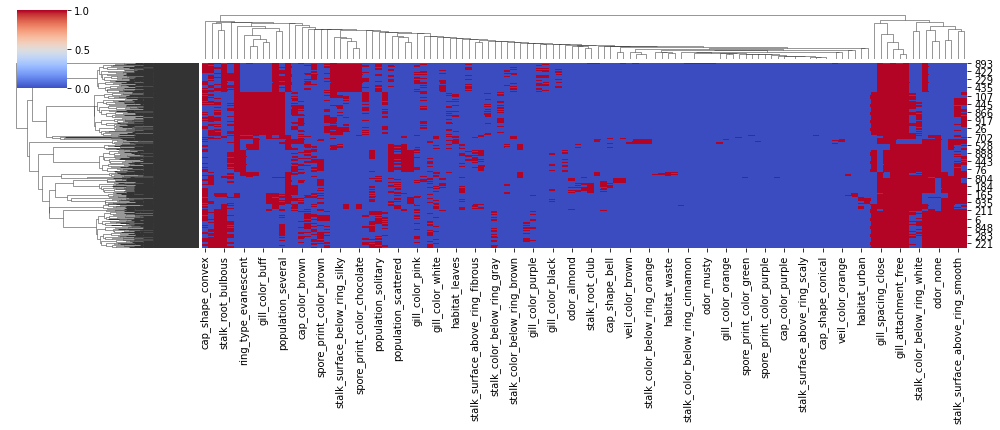

In [185]:
sns.clustermap(data_hold_out_X, metric='euclidean', cmap = "coolwarm", figsize = [14,6])

In [186]:
from scipy.spatial.distance import pdist, squareform

In [250]:
D = squareform(pdist(data_train_X.T.values, 'sokalmichener'))

In [251]:
col_names = list(data_train_X.columns)

In [256]:
D = pd.DataFrame(D)
D.columns = col_names
D.index = col_names

C:\Anaconda\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Anaconda\lib\site-packages\seaborn\matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


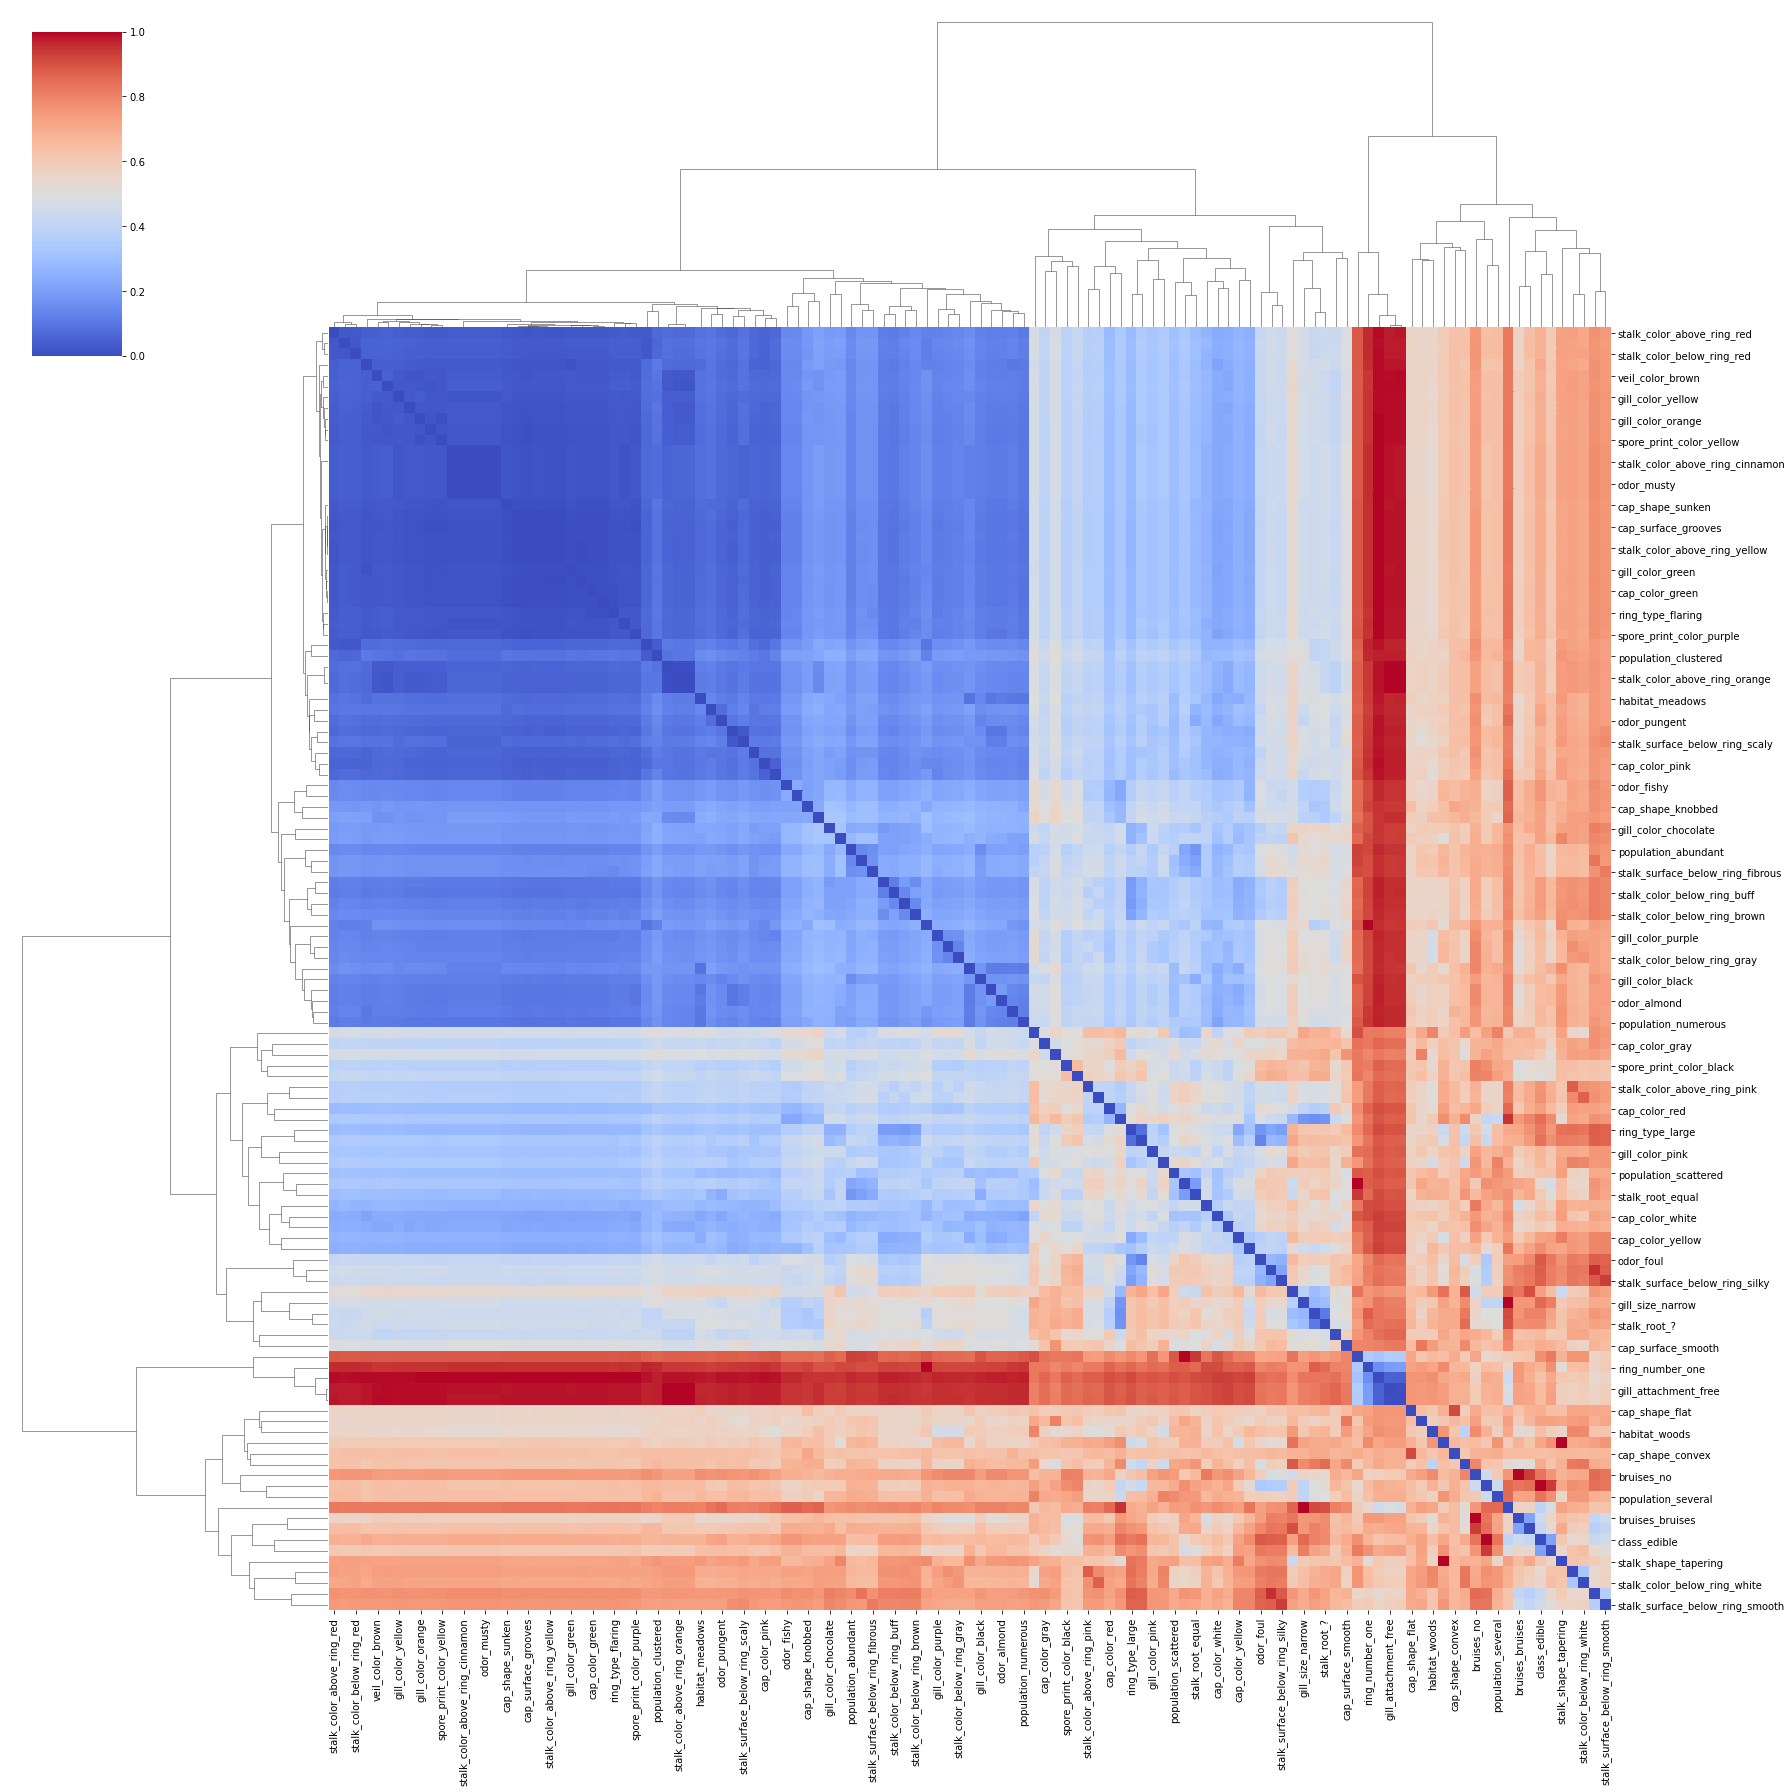

In [258]:
sns.clustermap(D, cmap = 'coolwarm', figsize = (25, 25));

In [383]:
y_train = pd.Series(data_train['class'])
y_test  = pd.Series(data_test['class'])

In [268]:
data_train_X

,bruises_bruises,bruises_no,cap_color_brown,cap_color_buff,cap_color_cinnamon,cap_color_gray,cap_color_green,cap_color_pink,cap_color_purple,cap_color_red,...,stalk_surface_above_ring_smooth,stalk_surface_below_ring_fibrous,stalk_surface_below_ring_scaly,stalk_surface_below_ring_silky,stalk_surface_below_ring_smooth,veil_color_brown,veil_color_orange,veil_color_white,veil_color_yellow,veil_type_partial
0,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1
3,0,1,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
2100,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2101,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2102,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1


In [280]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_train_X)

In [281]:
pc_df = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2', 'PC3'])

In [282]:
final_df = pd.concat([pc_df, y_train], axis = 1)

In [283]:
final_df

,PC1,PC2,PC3,class
0,1.901876,-1.678917,-0.684747,poisonous
1,1.940449,2.013012,0.611236,poisonous
2,-1.465396,0.787092,-1.348994,edible
3,1.997124,-1.532960,-0.939772,poisonous
4,-1.672661,0.562353,-1.178768,edible
...,...,...,...,...
2099,1.270571,-2.074872,-0.630280,poisonous
2100,-0.448382,0.509498,0.462865,poisonous
2101,2.453338,-1.493954,-0.419363,poisonous
2102,-1.413665,-0.837402,1.791476,edible


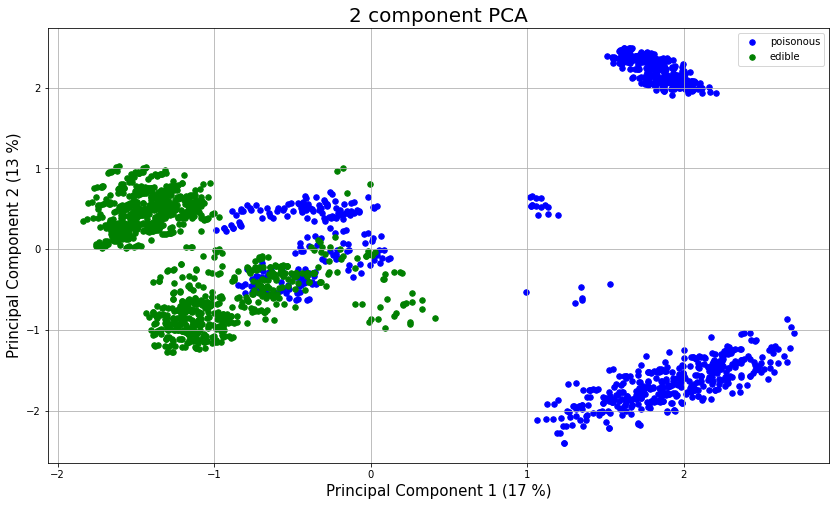

In [279]:
pc1 = int(pca.explained_variance_ratio_[0] * 100)
pc2 = int(pca.explained_variance_ratio_[1] * 100)
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component 1 ({pc1} %)', fontsize = 15)
ax.set_ylabel(f'Principal Component 2 ({pc2} %)', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['poisonous', 'edible']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['class'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'PC1']
               , final_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 30)
ax.legend(targets)
ax.grid()

In [284]:
x, y, z = final_df.iloc[:,0], final_df.iloc[:,1], final_df.iloc[:,2]

In [304]:
class_cols = y_train.replace(['poisonous', 'edible'],['#DB5461', '#3891A6'] )

In [364]:
cdict = {0:'#DB5461',1:'#3891A6'}
labl = {0:'Poisonous',1:'Edible'}
marker = {0:'*',1:'o'}

Text(0.5, 0, 'z')

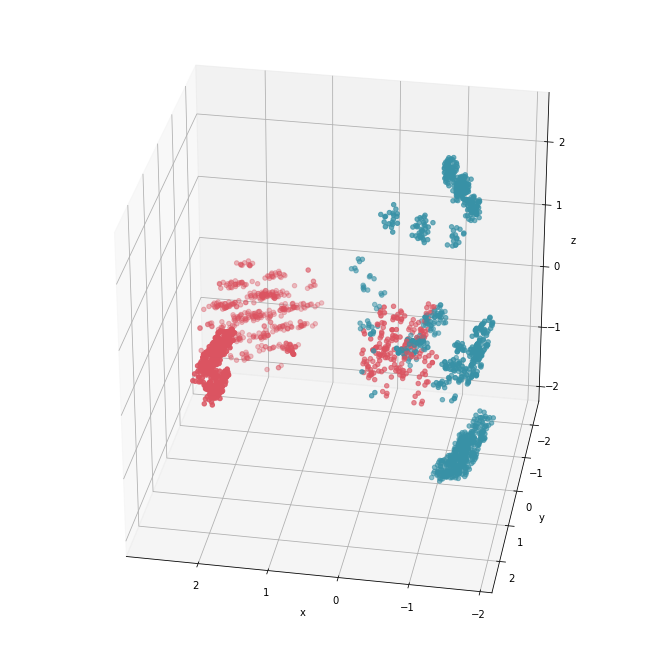

In [366]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (9, 9))
ax = Axes3D(fig)

ax.scatter(x, y, z, color = class_cols)
ax.view_init(30, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')



- - -
### 3. Построение классификатора:

In [367]:
data_train_X
data_hold_out_X

,bruises_bruises,bruises_no,cap_color_brown,cap_color_buff,cap_color_cinnamon,cap_color_gray,cap_color_green,cap_color_pink,cap_color_purple,cap_color_red,...,stalk_surface_above_ring_smooth,stalk_surface_below_ring_fibrous,stalk_surface_below_ring_scaly,stalk_surface_below_ring_silky,stalk_surface_below_ring_smooth,veil_color_brown,veil_color_orange,veil_color_white,veil_color_yellow,veil_type_partial
0,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
2,1,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,1
3,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1
943,0,1,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
944,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
945,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1


In [412]:
train_target = pd.Series(data_train['class'])
test_target  = pd.Series(data_test['class'])

In [413]:
X_train, X_test, y_train, y_test = train_test_split(data_train_X, train_target ,test_size=0.25,random_state=0)

In [414]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [415]:
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [417]:
train_acc = model.score(X_train, y_train)
print("The Accuracy for Train Set is {}".format(train_acc*100))
train_acc = model.score(X_test, y_test)
print("The Accuracy for Test Set is {}".format(train_acc*100))

train_acc = model.score(data_hold_out_X, test_target)
print("The Accuracy for Test Set 2 is {}".format(train_acc*100))


The Accuracy for Train Set is 100.0
The Accuracy for Test Set is 100.0
The Accuracy for Test Set 2 is 100.0


- - - 

In [418]:
svm = SVC(C=1, kernel='linear', random_state=1, probability = True)

In [419]:
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', probability=True, random_state=1)

In [422]:
y_pred = svm.predict(X=X_test)

In [426]:
train_acc = svm.score(X_train, y_train)
print("The Accuracy for Train Set is {}".format(train_acc*100))
train_acc = svm.score(X_test, y_test)
print("The Accuracy for Test Set is {}".format(train_acc*100))

train_acc = svm.score(data_hold_out_X, test_target)
print("The Accuracy for Test Set 2 is {}".format(train_acc*100))

The Accuracy for Train Set is 100.0
The Accuracy for Test Set is 100.0
The Accuracy for Test Set 2 is 100.0


- - -

In [427]:
tc = DecisionTreeClassifier()
tc.fit(X_train, y_train)

DecisionTreeClassifier()

In [428]:
y_pred = tc.predict(X_test)

In [430]:
train_acc = tc.score(X_train, y_train)
print("The Accuracy for Train Set is {}".format(train_acc*100))
train_acc = tc.score(X_test, y_test)
print("The Accuracy for Test Set is {}".format(train_acc*100))

train_acc = tc.score(data_hold_out_X, test_target)
print("The Accuracy for Test Set 2 is {}".format(train_acc*100))

The Accuracy for Train Set is 100.0
The Accuracy for Test Set is 100.0
The Accuracy for Test Set 2 is 100.0


- - -


In [433]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [434]:
y_pred = tc.predict(X_test)

In [436]:
train_acc = gbc.score(X_train, y_train)
print("The Accuracy for Train Set is {}".format(train_acc*100))
train_acc = gbc.score(X_test, y_test)
print("The Accuracy for Test Set is {}".format(train_acc*100))

train_acc = gbc.score(data_hold_out_X, test_target)
print("The Accuracy for Test Set 2 is {}".format(train_acc*100))

The Accuracy for Train Set is 100.0
The Accuracy for Test Set is 100.0
The Accuracy for Test Set 2 is 100.0


- - - 
### 4. Подбор оптимальных параметров (для SVM)

In [437]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [438]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.6s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.4s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.5s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.7s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.7s
[CV] END ...................

[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [439]:
print(grid.best_estimator_)

SVC(C=0.1, gamma=1, kernel='poly')


In [440]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))

[[286   0]
 [  0 240]]


In [441]:
train_acc = grid.score(data_hold_out_X, test_target)
print("The Accuracy for Test Set 2 is {}".format(train_acc*100))

The Accuracy for Test Set 2 is 100.0


- - -
### 5. Оценка качества полученных моделей с использованием тестового набора 

In [445]:
train_acc = model.score(data_hold_out_X, test_target)
print("The Accuracy for Test Set is {}".format(train_acc*100))

The Accuracy for Test Set is 100.0


In [451]:
y_pred = tc.predict(data_hold_out_X)

In [462]:
y_pred = np.where(y_pred == "poisonous", 0, 1)

In [ ]:
test_target = test_target.replace(['poisonous', 'edible'],['0', '1'] )

In [470]:
test_target = test_target.to_numpy()

In [463]:
test_target = test_target.astype(np.int)

In [484]:
y_pred = y_pred.astype(np.int)

In [490]:
fpr, tpr, thresholds = roc_curve(test_target, y_pred, drop_intermediate=False)

In [491]:
auc = roc_auc_score(test_target, y_pred)
print('AUC: %.3f' % auc)

AUC: 1.000


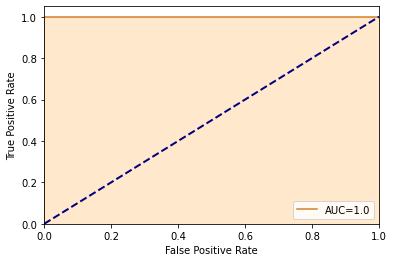

In [492]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label="AUC="+str(auc), color='#D1802A')
ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_ylabel('True Positive Rate')  
ax.set_xlabel('False Positive Rate')
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05])
ax.legend(loc=4)

- - -
### 6. Оцените важность признаков

In [493]:
importance = model.coef_[0]

In [494]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.22612
Feature: 1, Score: 0.23506
Feature: 2, Score: -0.08539
Feature: 3, Score: 0.20433
Feature: 4, Score: -0.08582
Feature: 5, Score: -0.10540
Feature: 6, Score: -0.10190
Feature: 7, Score: 0.21595
Feature: 8, Score: -0.07224
Feature: 9, Score: 0.06497
Feature: 10, Score: 0.17273
Feature: 11, Score: -0.19830
Feature: 12, Score: -0.04117
Feature: 13, Score: 0.13521
Feature: 14, Score: -0.05676
Feature: 15, Score: 0.05540
Feature: 16, Score: 0.00075
Feature: 17, Score: -0.08449
Feature: 18, Score: -0.36230
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.11328
Feature: 21, Score: 0.25796
Feature: 22, Score: -3.29528
Feature: 23, Score: 3.30422
Feature: 24, Score: -0.06124
Feature: 25, Score: 0.07019
Feature: 26, Score: -0.12636
Feature: 27, Score: -0.23900
Feature: 28, Score: 0.57300
Feature: 29, Score: 0.10585
Feature: 30, Score: 0.08545
Feature: 31, Score: 0.13071
Feature: 32, Score: -0.03313
Feature: 33, Score: -0.09018
Feature: 34, Score: -0.16813
Feature: 35,

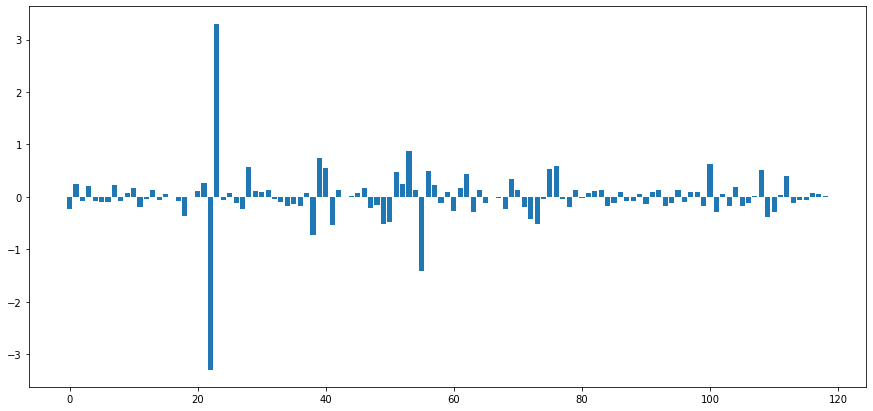

In [498]:
plt.figure(figsize=(15,7))
plt.bar([x for x in range(len(importance))], importance)
plt.show()